## Pure Jax

In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap

# 1. Define the Neural Network (MLP)
# JAX encourages pure functions, so parameters are explicitly passed.
def init_mlp_params(key, layer_sizes):
    """Initializes the weights and biases for an MLP."""
    params = []
    for i in range(len(layer_sizes) - 1):
        in_dim, out_dim = layer_sizes[i], layer_sizes[i+1]
        # Glorot initialization for weights
        std_dev = jnp.sqrt(2.0 / (in_dim + out_dim))
        key, subkey = random.split(key)
        weights = random.normal(subkey, (in_dim, out_dim)) * std_dev
        biases = jnp.zeros(out_dim)
        params.append({'weights': weights, 'biases': biases})
    return params

def mlp_forward(params, x):
    """Performs a forward pass through the MLP."""
    hidden_layers = params[:-1]
    output_layer = params[-1]

    for layer in hidden_layers:
        x = jnp.dot(x, layer['weights']) + layer['biases']
        x = jax.nn.relu(x) # ReLU activation for hidden layers

    # No activation for the output layer (e.g., for value prediction)
    output = jnp.dot(x, output_layer['weights']) + output_layer['biases']
    return output

# 2. Define the Loss Function (e.g., Mean Squared Error)
def mse_loss(params, x_batch, y_batch):
    """Calculates the Mean Squared Error loss."""
    predictions = mlp_forward(params, x_batch)
    return jnp.mean((predictions - y_batch)**2)

# 3. Define the Update Function (Gradient Descent)
# We'll JIT this for performance.
@jit
def update(params, x_batch, y_batch, learning_rate):
    """Computes gradients and updates parameters using Adam optimizer."""
    grads = grad(mse_loss)(params, x_batch, y_batch)

    # Simple SGD update for demonstration. For RL, you'd typically use Adam, RMSprop, etc.
    # In JAX, you'd implement Adam yourself or use a library like Optax.
    new_params = []
    for i in range(len(params)):
        new_weights = params[i]['weights'] - learning_rate * grads[i]['weights']
        new_biases = params[i]['biases'] - learning_rate * grads[i]['biases']
        new_params.append({'weights': new_weights, 'biases': new_biases})
    return new_params

# 4. Simulation of a Training Loop (for a value function example)
if __name__ == "__main__":
    # Hyperparameters
    input_dim = 10
    output_dim = 1 # e.g., predicting a single value
    hidden_layer_sizes = [64, 64]
    layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
    learning_rate = 0.001
    num_epochs = 1000
    batch_size = 32

    # Initialize random key for parameter initialization and data generation
    key = random.PRNGKey(0)
    param_key, data_key = random.split(key)

    # Initialize MLP parameters
    params = init_mlp_params(param_key, layer_sizes)

    print("Initial parameters (weights of first layer):\n", params[0]['weights'][:2, :2])

    # Generate some dummy data (e.g., states and their true values)
    # In RL, x_batch would be states, and y_batch would be target values (e.g., Q-values, V-values)
    num_samples = 1000
    x_data = random.normal(data_key, (num_samples, input_dim))
    # A simple arbitrary function to generate target values for demonstration
    y_data = jnp.sum(x_data, axis=1, keepdims=True) * 0.5 + 2.0 + random.normal(data_key, (num_samples, 1)) * 0.1

    print(f"\nTraining an MLP with {layer_sizes} layers for {num_epochs} epochs...")

    # Training loop
    for epoch in range(num_epochs):
        # Create a new key for data shuffling/batching in each epoch
        data_key, _ = random.split(data_key)
        permutation = random.permutation(data_key, num_samples)
        shuffled_x = x_data[permutation]
        shuffled_y = y_data[permutation]

        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            batch_x = shuffled_x[start_idx:end_idx]
            batch_y = shuffled_y[start_idx:end_idx]

            params = update(params, batch_x, batch_y, learning_rate)
            epoch_loss += mse_loss(params, batch_x, batch_y)

        epoch_loss /= num_batches
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("\nTraining complete!")
    print("Final parameters (weights of first layer):\n", params[0]['weights'][:2, :2])

    # Demonstrate prediction on new data
    test_key, _ = random.split(key)
    test_x = random.normal(test_key, (5, input_dim))
    predictions = mlp_forward(params, test_x)
    print("\nTest predictions:\n", predictions)
    print("True values (for comparison):\n", jnp.sum(test_x, axis=1, keepdims=True) * 0.5 + 2.0)

    # --- Illustrating vmap (for batched predictions in RL inference) ---
    print("\n--- Demonstrating vmap for batched inference ---")
    # Let's say you have multiple independent agents, and each needs a prediction.
    # Or you want to evaluate multiple states at once efficiently without explicit loops.

    # Original forward function
    # def mlp_forward(params, x): ...

    # Vmapped version: allows `mlp_forward` to operate on a batch of `x`
    # The 'in_axes' specifies which arguments are batched.
    # Here, params are static (not batched), and x is batched along its 0th axis.
    batched_mlp_forward = vmap(mlp_forward, in_axes=(None, 0)) # None for params, 0 for x

    # Create a batch of states
    batch_states = random.normal(test_key, (10, input_dim)) # 10 states

    # Now call the vmapped function
    batched_predictions = batched_mlp_forward(params, batch_states)
    print(f"Shape of batched_predictions (from {batch_states.shape[0]} states): {batched_predictions.shape}")
    print("First 3 batched predictions:\n", batched_predictions[:3])

Initial parameters (weights of first layer):
 [[-0.20672804 -0.06602336]
 [ 0.16547312  0.01654976]]

Training an MLP with [10, 64, 64, 1] layers for 1000 epochs...
Epoch 100/1000, Loss: 0.0547
Epoch 200/1000, Loss: 0.0287
Epoch 300/1000, Loss: 0.0222
Epoch 400/1000, Loss: 0.0191
Epoch 500/1000, Loss: 0.0172
Epoch 600/1000, Loss: 0.0157
Epoch 700/1000, Loss: 0.0146
Epoch 800/1000, Loss: 0.0134
Epoch 900/1000, Loss: 0.0129
Epoch 1000/1000, Loss: 0.0123

Training complete!
Final parameters (weights of first layer):
 [[-0.20008582 -0.05496537]
 [ 0.15554295  0.00699459]]

Test predictions:
 [[0.50519556]
 [2.824003  ]
 [2.3632827 ]
 [2.026969  ]
 [3.676911  ]]
True values (for comparison):
 [[0.68233883]
 [2.789906  ]
 [2.59621   ]
 [1.7178085 ]
 [3.7331963 ]]

--- Demonstrating vmap for batched inference ---
Shape of batched_predictions (from 10 states): (10, 1)
First 3 batched predictions:
 [[0.50519556]
 [2.824003  ]
 [2.363283  ]]


## NNX

In [8]:
from flax.experimental import nnx
import jax
import jax.numpy as jnp

### Module System(Refer to obsidian)

In [3]:
class Linear(nnx.Module):
  def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):
    key = rngs.params()
    self.w = nnx.Param(jax.random.uniform(key, (din, dout)))
    self.b = nnx.Param(jnp.zeros((dout,)))
    self.din, self.dout = din, dout

  def __call__(self, x: jax.Array):
    return x @ self.w + self.b

In [4]:
model = Linear(2, 5, rngs=nnx.Rngs(params=0))
y = model(x=jnp.ones((1, 2)))

print(y)
nnx.display(model)

[[1.5643291  0.94782424 0.37971854 1.0724319  0.22112393]]


### Nested Modules

In [10]:
class MLP(nnx.Module):
  def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
    self.linear1 = Linear(din, dmid, rngs=rngs)
    self.dropout = nnx.Dropout(rate=0.1, rngs=rngs)
    self.bn = nnx.BatchNorm(dmid, rngs=rngs)
    self.linear2 = Linear(dmid, dout, rngs=rngs)

  def __call__(self, x: jax.Array):
    x = nnx.gelu(self.dropout(self.bn(self.linear1(x))))
    return self.linear2(x)

model = MLP(2, 16, 5, rngs=nnx.Rngs(0))

y = model(x=jnp.ones((3, 2)))

nnx.display(model)

In [6]:
import optax

# MLP contains 2 Linear layers, 1 Dropout layer, 1 BatchNorm layer
model = MLP(2, 16, 10, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))  # reference sharing

@nnx.jit  # automatic state management
def train_step(model, optimizer, x, y):
  def loss_fn(model: MLP):
    y_pred = model(x)
    return jnp.mean((y_pred - y) ** 2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates

  return loss

x, y = jnp.ones((5, 2)), jnp.ones((5, 10))
loss = train_step(model, optimizer, x, y)

print(f'{loss = }')
print(f'{optimizer.step.value = }')

loss = Array(1.0000623, dtype=float32)
optimizer.step.value = Array(1, dtype=uint32)


## MINIST example

In [13]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf  # TensorFlow operations

tf.random.set_seed(0)  # set random seed for reproducibility

num_epochs = 10
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize test set

# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
test_ds = test_ds.shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.6LYI0I_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.6LYI0I_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [14]:
from flax.experimental import nnx  # NNX API
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

model = CNN(rngs=nnx.Rngs(0))
nnx.display(model)

In [15]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
nnx.display(y)

In [16]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [17]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

In [18]:
@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])
  optimizer.update(grads)

In [19]:
@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])

In [20]:
tf.random.set_seed(0)

In [21]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - the train state's model parameters
  # - the optimizer state
  # - the training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if (step + 1) % num_steps_per_epoch == 0:  # one training epoch has passed
    # Log training metrics
    for metric, value in metrics.compute().items():  # compute metrics
      metrics_history[f'train_{metric}'].append(value)  # record metrics
    metrics.reset()  # reset metrics for test set

    # Compute metrics on the test set after each training epoch
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log test metrics
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # reset metrics for next training epoch

    print(
      f"train epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"test epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

train epoch: 1, loss: 0.10447724908590317, accuracy: 96.78666687011719
test epoch: 1, loss: 0.05511069297790527, accuracy: 98.14703369140625
train epoch: 2, loss: 0.04511391371488571, accuracy: 98.64166259765625
test epoch: 2, loss: 0.04217041656374931, accuracy: 98.64784240722656
train epoch: 3, loss: 0.033317696303129196, accuracy: 98.96833038330078
test epoch: 3, loss: 0.04502986744046211, accuracy: 98.64784240722656
train epoch: 4, loss: 0.02761215902864933, accuracy: 99.1816635131836
test epoch: 4, loss: 0.040992338210344315, accuracy: 98.73797607421875
train epoch: 5, loss: 0.02016105130314827, accuracy: 99.3933334350586
test epoch: 5, loss: 0.04529605805873871, accuracy: 98.85816955566406
train epoch: 6, loss: 0.019481085240840912, accuracy: 99.40833282470703
test epoch: 6, loss: 0.04791458696126938, accuracy: 98.86819458007812
train epoch: 7, loss: 0.017105605453252792, accuracy: 99.4766616821289
test epoch: 7, loss: 0.0621553398668766, accuracy: 98.65785217285156
train epoch: 

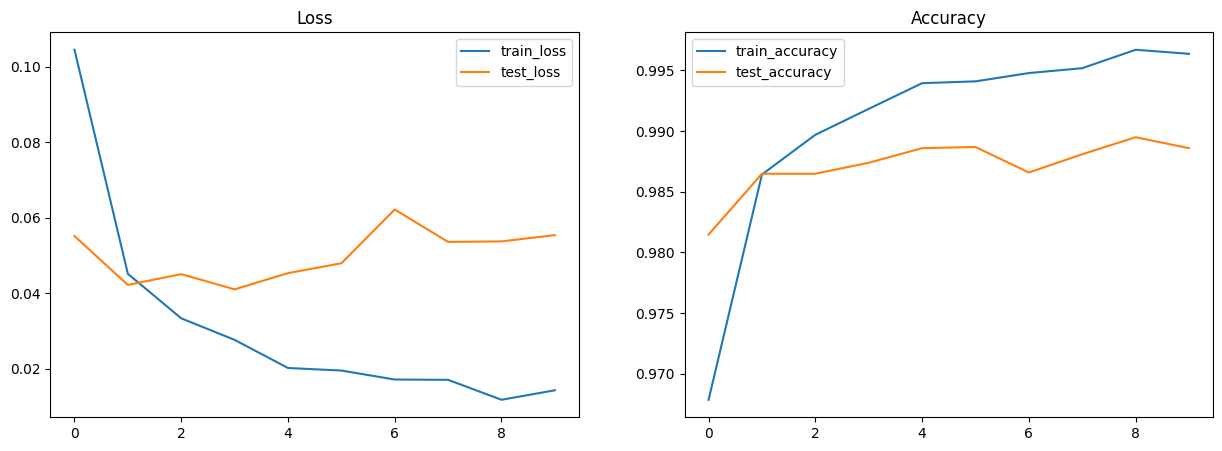

In [22]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [23]:
@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

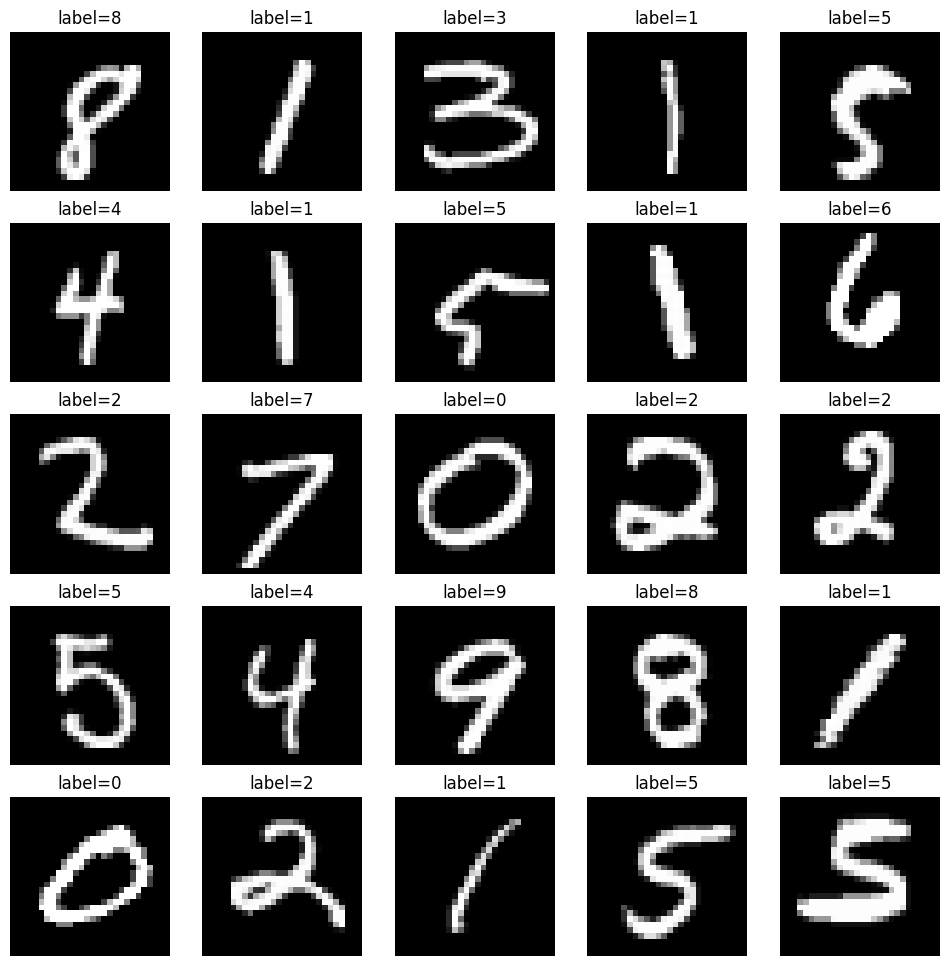

In [24]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')